In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from qlty import qlty2D
from dlsia.core.networks import tunet, msdnet

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/shai/opt/anaconda3/envs/summer_2024_research/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/shai/opt/anaconda3/envs/summer_2024_research/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <9B280146-BBD7-3F77-9873-F9740F2A5329> /Users/shai/opt/anaconda3/envs/summer_2024_research/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <650A7408-F84B-37A3-B9D0-8E799E9E0543> /Users/shai/opt/anaconda3/envs/summer_2024_research/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
input_directory = "../data/input/LBNL_ALS_Scattering_data_jpg"
output_directory = "../data/output/LBNL_ALS_Scattering_data_jpg_inpainted"
os.makedirs(output_directory, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


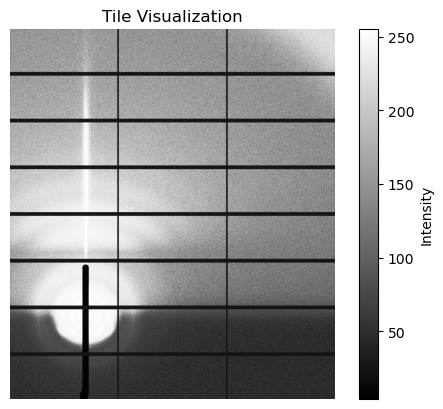

(1475, 1679)


In [5]:
filename = os.listdir(input_directory)[0]
image_path = os.path.join(input_directory, filename)
output_path = os.path.join(output_directory, filename)

# Load and preprocess the image
image = Image.open(image_path).convert("L")  # Convert to grayscale
plt.figure()
plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale
plt.colorbar(label='Intensity')
plt.title('Tile Visualization')
plt.axis('off')
plt.show()

print (image.size)

In [6]:
# Define image transformations
def safe_divide(x):
    max_val = x.max()
    if max_val > 0:
        return x / max_val
    else:
        return x

def safe_log1p(x):
    return torch.log1p(torch.clamp(x, min=0))

transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Lambda(safe_divide),
    transforms.Lambda(safe_log1p)
])

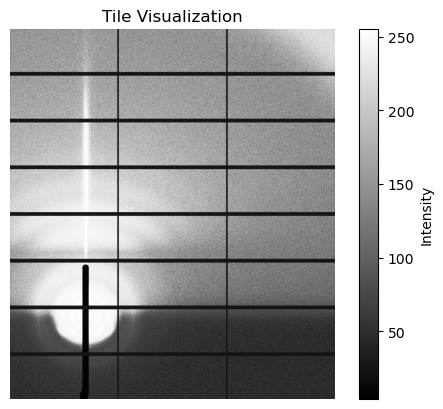

Loaded and preprocessed image: 00000038.jpg
torch.Size([1, 1, 512, 512])


In [7]:
# Transformed image
input_tensor = transform(image)
plt.figure()
plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale
plt.colorbar(label='Intensity')
plt.title('Tile Visualization')
plt.axis('off')
plt.show()

input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

input_tensor = input_tensor.to(device)

# input_image_np = np.array(image)  # Original input image as a NumPy array
# input_min, input_max = input_image_np.min(), input_image_np.max()  # Get original intensity range

print(f"Loaded and preprocessed image: {filename}")
print (input_tensor.shape)

Unstitched image into 7 tiles
torch.Size([7, 1, 512, 128])
tile 0 shape: torch.Size([1, 512, 128])


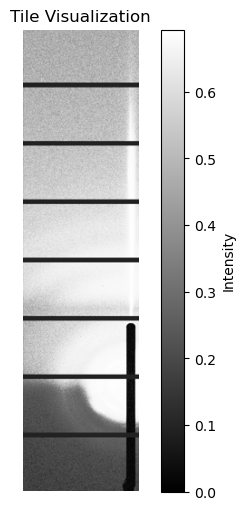

tile 1 shape: torch.Size([1, 512, 128])


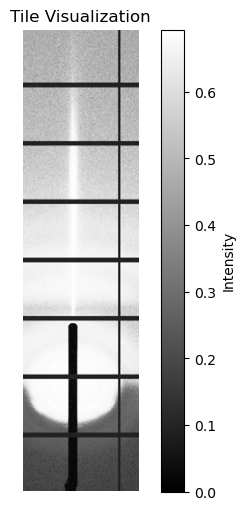

tile 2 shape: torch.Size([1, 512, 128])


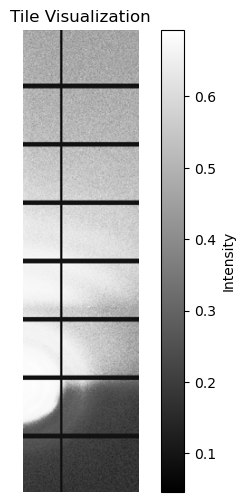

tile 3 shape: torch.Size([1, 512, 128])


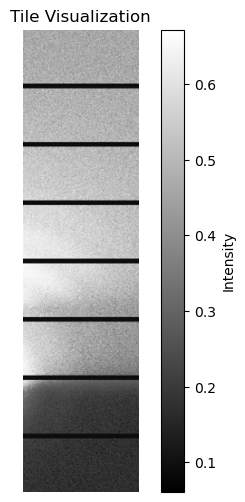

tile 4 shape: torch.Size([1, 512, 128])


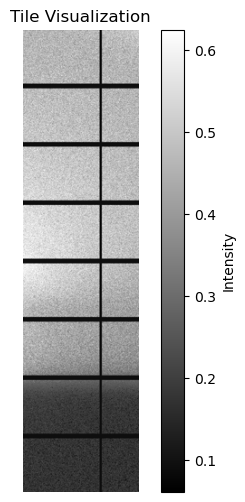

tile 5 shape: torch.Size([1, 512, 128])


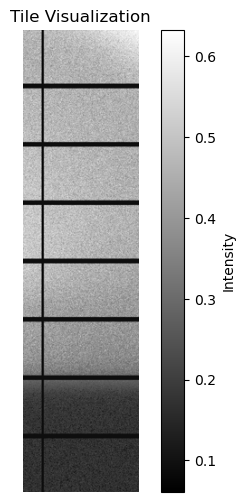

tile 6 shape: torch.Size([1, 512, 128])


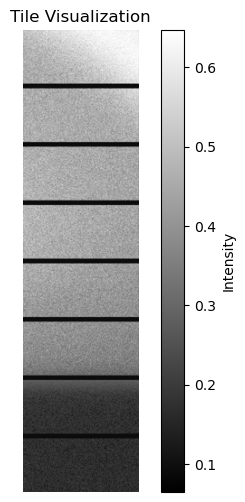

In [10]:
quilt = qlty2D.NCYXQuilt(X=512,
                         Y=512,
                         window=(512, 128),
                         step=(512, 64),
                         border=(0, 0),
                         border_weight=0)

# Unstitching using qlty
try:
    output = []
    input_tensor_cpu = input_tensor.cpu()
    tiles = quilt.unstitch(input_tensor_cpu)
    print(f"Unstitched image into {tiles.shape[0]} tiles")
    print(tiles.shape)
    for i in range(len(tiles)):
        print (f"tile {i} shape: {tiles[i].shape}")
        tile = tiles[i].unsqueeze(0).to(device)
        output.append(tile)
        # Remove the batch dimension
        tile_image = tiles[i].squeeze(0).numpy()  # Now the shape is (512, 128)

        plt.figure(figsize=(6, 6))
        plt.imshow(tile_image, cmap='gray')  # Use 'gray' colormap for grayscale
        plt.colorbar(label='Intensity')
        plt.title('Tile Visualization')
        plt.axis('off')
        plt.show()
except Exception as e:
    print(f"Failed during unstitching: {e}")


Output tensor shape: torch.Size([7, 1, 512, 128])
Output tensor dtype: torch.float32
Final output shape: torch.Size([1, 1, 512, 512])
Final output dtype: torch.float32
Final output shape 2: torch.Size([1, 1, 512, 512])


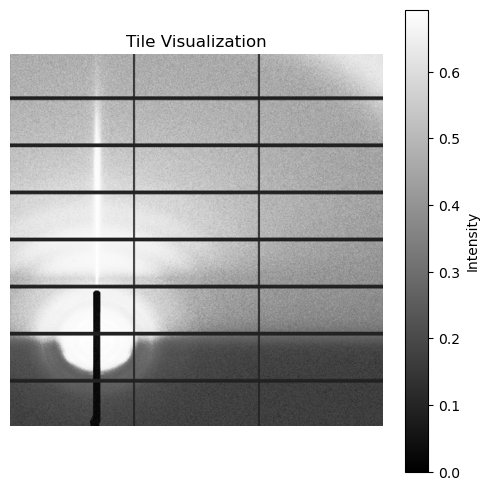

In [11]:
# output_tensor = torch.stack(outputs)
output_tensor = torch.cat(output, dim=0)
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Output tensor dtype: {output_tensor.dtype}")
final_output, weights = quilt.stitch(output_tensor)
print(f"Final output shape: {final_output.shape}")
print(f"Final output dtype: {final_output.dtype}")

final_output_np = final_output.squeeze().numpy()
print(f"Final output shape 2: {final_output.shape}")

plt.figure(figsize=(6, 6))
plt.imshow(final_output_np, cmap='gray')  # Use 'gray' colormap for grayscale
plt.colorbar(label='Intensity')
plt.title('Tile Visualization')
plt.axis('off')
plt.show()
